**Univariate Time Series Forecasting with NimbusML**

In [325]:
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
from nimbusml import Pipeline
from nimbusml.timeseries import SsaForecaster
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [69]:
# Load image summary data from github
url_to_csv = "https://raw.githubusercontent.com/mstfbl/NimbusML-Samples/Issue-22/datasets/max_planck_weather_time_series_dataset.csv"
df_train = pd.read_csv(filepath_or_buffer=url_to_csv, sep = ",",)

In [70]:
# Set constant random seed
random.seed(30)

Let's look at our data.

In [71]:
df_train.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.10
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.60
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.00
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.30


In [72]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [73]:
TRAIN_SPLIT = 300000

**Single-step prediction**

In [74]:
data_univariate = df_train['T (degC)']
data_univariate.index = df_train['Date Time']
data_univariate.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000224AD879B70>],
      dtype=object)

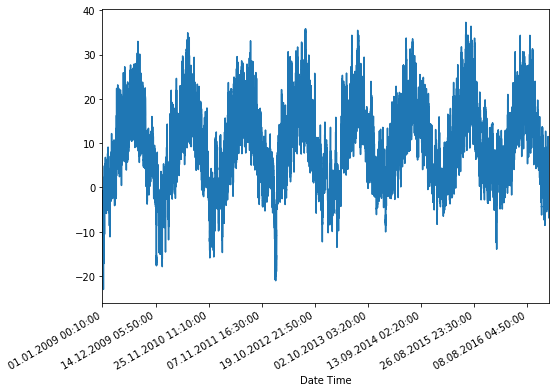

In [75]:
data_univariate.plot(subplots=True)

In [76]:
data_univariate = data_univariate.values
data_univariate_mean = data_univariate[:TRAIN_SPLIT].mean()
data_univariate_std = data_univariate[:TRAIN_SPLIT].std()
data_univariate = (data_univariate-data_univariate_mean)/data_univariate_std

In [211]:
univariate_past_history = 21
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(data_univariate, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(data_univariate, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [212]:
print(len(x_val_uni))

120530


In [213]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]
 [-2.10418486]]

 Target temperature to predict
-2.0949220845536356


In [214]:
def create_time_steps(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)
  return time_steps

In [215]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\mubal\\AppData\\Roaming\\Python\\Python36\\site-packages\\matplotlib\\pyplot.py'>

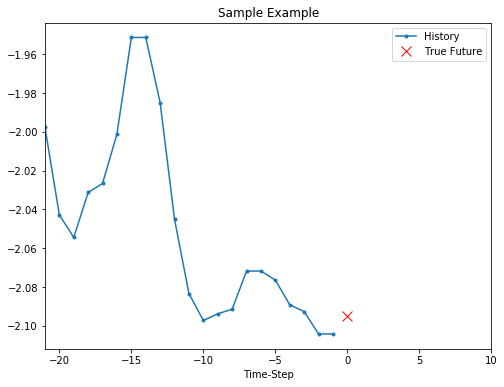

In [216]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

In [217]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from 'C:\\Users\\mubal\\AppData\\Roaming\\Python\\Python36\\site-packages\\matplotlib\\pyplot.py'>

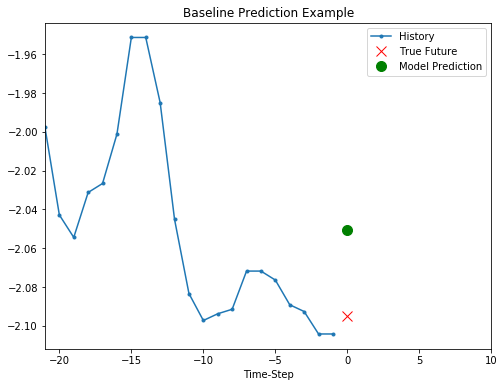

In [218]:
#print(x_train_uni[0])
#print(y_train_uni[0])
#print(baseline(x_train_uni[0]))
#print(x_train_uni.shape[-2:])
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0, 'Baseline Prediction Example')

In [219]:
x_val_uni_list = [x[0] for x in x_val_uni[0].tolist()]
X_val_ssa = pd.Series(x_val_uni_list, name="T (degC)")
print(X_val_ssa)
print(len(x_train_uni[0])) #almost 2100 days worth of data
x_train_uni_list_big = x_train_uni.flatten()
X_train_ssa_big = pd.Series(x_train_uni_list_big, name="T (degC)")
print(X_train_ssa_big)

0    0.64
1    0.64
2    0.64
3    0.64
4    0.64
5    0.64
6    0.64
7    0.64
8    0.63
9    0.63
10   0.63
11   0.63
12   0.62
13   0.62
14   0.61
15   0.61
16   0.61
17   0.60
18   0.60
19   0.60
20   0.60
Name: T (degC), dtype: float64
21
0         -2.00
1         -2.04
2         -2.05
3         -2.03
4         -2.03
           ... 
6299554    0.65
6299555    0.65
6299556    0.65
6299557    0.64
6299558    0.64
Name: T (degC), Length: 6299559, dtype: float64


In [220]:
#seasonality_size = 52560 # 365 (length of season in days) * 144 (with 10 minute interval samples, 144 samples in one day)
#training_seasons = 749950 #roughly 8 seasons displayed in entire dataset, so len(X_train_ssa_big) / 8
#training_size = seasonality_size * training_seasons
#pipeline = Pipeline([
#    SsaForecaster(series_length= 449996, #arbitrary for now
#                  train_size= training_size,
#                  window_size= seasonality_size + 1,
#                  horizon=3,
#                  columns={'T (degC)_fc': 'T (degC)'})
#])

In [224]:
# Parameters to be tuned later
pipeline = Pipeline([
    SsaForecaster(series_length=6,
                  train_size=20,
                  window_size=3,
                  horizon=1,
                  columns={'T (degC)_fc': 'T (degC)'})
])

In [225]:
print(len(X_train_ssa_big))
pipeline.fit(X_train_ssa_big)
print(X_train_ssa_big)

6299559
Elapsed time: 00:00:00.0379467
0         -2.00
1         -2.04
2         -2.05
3         -2.03
4         -2.03
           ... 
6299554    0.65
6299555    0.65
6299556    0.65
6299557    0.64
6299558    0.64
Name: T (degC), Length: 6299559, dtype: float64


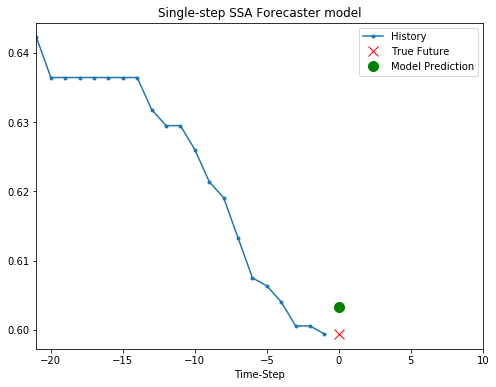


[[0.642228  ]
 [0.63643877]
 [0.63643877]
 [0.63643877]
 [0.63643877]
 [0.63643877]
 [0.63643877]
 [0.63643877]
 [0.63180738]
 [0.62949169]
 [0.62949169]
 [0.62601815]
 [0.62138676]
 [0.61907107]
 [0.61328183]
 [0.6074926 ]
 [0.60633475]
 [0.60401906]
 [0.60054552]
 [0.60054552]
 [0.59938767]] 0.5993876681669458 0.60325193
    T (degC)  T (degC)_fc.0
0       0.64          -1.42
1       0.64          -0.50
2       0.64           0.41
3       0.64           0.64
4       0.64           0.64
5       0.64           0.64
6       0.64           0.64
7       0.64           0.64
8       0.63           0.64
9       0.63           0.64
10      0.63           0.63
11      0.63           0.63
12      0.62           0.63
13      0.62           0.63
14      0.61           0.62
15      0.61           0.62
16      0.61           0.61
17      0.60           0.61
18      0.60           0.61
19      0.60           0.60
20      0.60           0.60


In [226]:
predicted_val_uni = pipeline.transform(X_val_ssa)
predicted_val = predicted_val_uni['T (degC)_fc.0'][20]
plot = show_plot([x_val_uni[0], y_val_uni[0], predicted_val], 0, 'Single-step SSA Forecaster model')
plot.show()
print()
print(x_val_uni[0], y_val_uni[0], predicted_val)
print(predicted_val_uni)

In [227]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

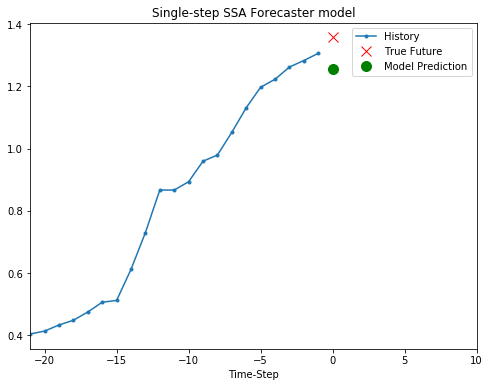

Absolute Percentage Error: 8.179844


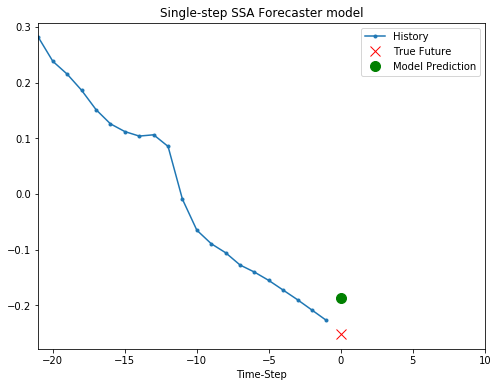

In [ ]:
for i in range(3):
    # Predicting
    random_i = random.randint(0, len(x_val_uni))
    x_val_uni_list = [x[0] for x in x_val_uni[random_i].tolist()]
    X_val_ssa = pd.Series(x_val_uni_list, name="T (degC)")
    predicted_val_uni = pipeline.transform(X_val_ssa)
    predicted_val = predicted_val_uni['T (degC)_fc.0'][19]
    plot = show_plot([x_val_uni[random_i], y_val_uni[random_i], predicted_val], 0, 'Single-step SSA Forecaster model')
    plot.show()
    # Performace
    abe = (abs(1.00 * y_val_uni[random_i] - predicted_val)) / predicted_val * 100
    print('Absolute Percentage Error: %f' % abe)

**Multi-step prediction**

In [230]:
features_considered = ['T (degC)']

In [231]:
features = df_train[features_considered]
features.index = df_train['Date Time']
features.head()

,T (degC)
Date Time,
01.01.2009 00:10:00,-8.02
01.01.2009 00:20:00,-8.41
01.01.2009 00:30:00,-8.51
01.01.2009 00:40:00,-8.31
01.01.2009 00:50:00,-8.27


array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000224BDE22710>],
      dtype=object)

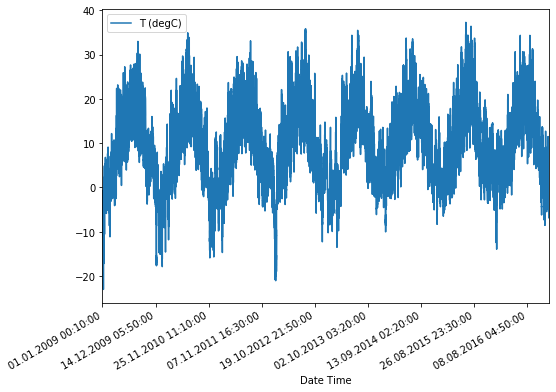

In [232]:
features.plot(subplots=True)

In [233]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [234]:
dataset = (dataset-data_mean)/data_std

420551


In [235]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [236]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 1)


In [237]:
past_history = 720
future_target = 72
STEP = 6
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 0], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 0],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [239]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

In [240]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 0]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

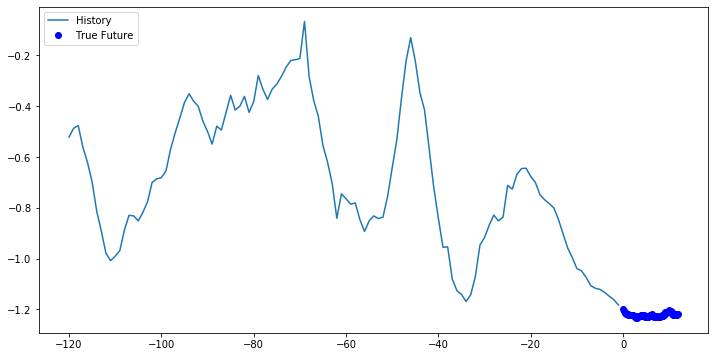

In [241]:
random_i = random.randint(0, len(x_train_multi))
multi_step_plot(x_train_multi[random_i], y_train_multi[random_i], np.array([0]))

In [243]:
x_train_multi_list_big = x_train_multi.flatten()
X_train_multi_ssa_big = pd.Series(x_train_multi_list_big, name="T (degC)")
print(X_train_multi_ssa_big)

0          -2.00
1          -1.95
2          -2.09
3          -2.09
4          -2.14
            ... 
35913595    0.69
35913596    0.69
35913597    0.68
35913598    0.66
35913599    0.65
Name: T (degC), Length: 35913600, dtype: float64


In [313]:
seasonality_size = 20
training_seasons = 4
training_size = seasonality_size * training_seasons
pipeline_multi = Pipeline([
    SsaForecaster(series_length= 90,
                  train_size= training_size,
                  window_size= seasonality_size + 1,
                  horizon=72,
                  columns={'T (degC)_fc': 'T (degC)'})
])

In [314]:
pipeline_multi.fit(X_train_multi_ssa_big)

Elapsed time: 00:00:00.0386314


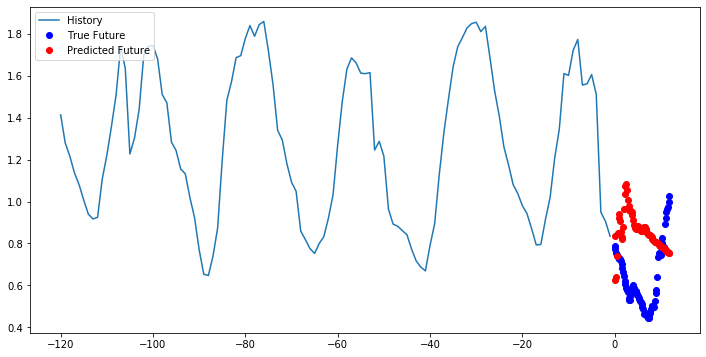

Bias/Mean Forecast Error: 0.216632
Mean Absolute Error: 0.264761
Mean Squared Error: 0.089275
Root Mean Squared Error: 0.298788
Mean Absolute Percentage Error: 30.212132


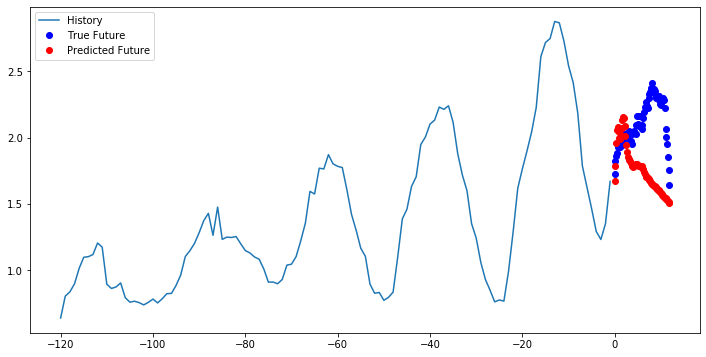

Bias/Mean Forecast Error: -0.349264
Mean Absolute Error: 0.385194
Mean Squared Error: 0.207232
Root Mean Squared Error: 0.455227
Mean Absolute Percentage Error: 23.047102


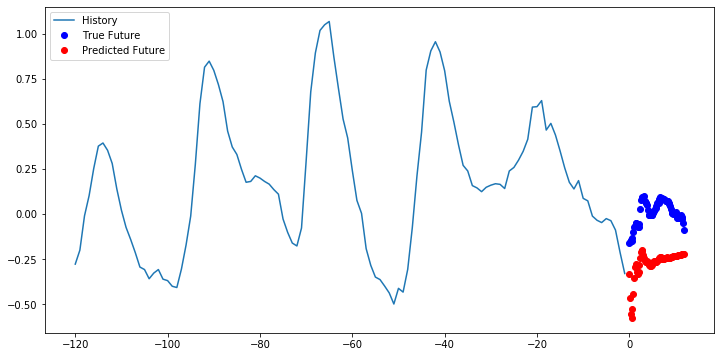

Bias/Mean Forecast Error: -0.280667
Mean Absolute Error: 0.280667
Mean Squared Error: 0.081713
Root Mean Squared Error: 0.285854
Mean Absolute Percentage Error: 106.205156


In [334]:
for _ in range(3):
    # Predicting
    random_i = random.randint(0, len(x_val_multi))
    x_val_multi_list = [x[0] for x in x_val_multi[random_i].tolist()]
    X_val_multi_ssa = pd.Series(x_val_multi_list, name="T (degC)")
    transformed_horizons = pipeline_multi.transform(X_val_multi_ssa)
    #print(transformed_horizons)
    predicted_vals_multi = [0 for _ in range(73)]
    count = 0
    for (_, columnData) in transformed_horizons.iteritems():
        #print(columnData.values[119])
        predicted_vals_multi[count] = columnData.values[119]
        count += 1
    multi_step_plot(x_val_multi[random_i], y_val_multi[random_i], np.asarray(predicted_vals_multi[:-1]))
    # Performance
    # forecast_error = expected_value - predicted_value
    # bias = mean_forecast_error = mean(forecast_error)
    # mean_absolute_error = mean( abs(forecast_error) )
    # mean_squared_error = mean_squared_error = mean(forecast_error^2)
    # rmse = sqrt(mean_squared_error)
    # mean absolute percentage error = mean(((y_true - y_pred) / y_true)) * 100)
    expected = predicted_vals_multi[:-1]
    predictions = y_val_multi[random_i]
    forecast_errors = [expected[i]-predictions[i] for i in range(len(y_val_multi[random_i]))]
    #print('Forecast Errors: %s' % forecast_errors)
    bias = sum(forecast_errors) * 1.0/len(expected)
    print('Bias/Mean Forecast Error: %f' % bias)
    mae = mean_absolute_error(expected, predictions)
    print('Mean Absolute Error: %f' % mae)
    mse = mean_squared_error(expected, predictions)
    print('Mean Squared Error: %f' % mse)
    rmse = sqrt(mse)
    print('Root Mean Squared Error: %f' % rmse)
    mape = sum([abs((1.00*expected[i]-predictions[i])/expected[i]*100) for i in range(len(y_val_multi[random_i]))]) / len(expected)
    print('Mean Absolute Percentage Error: %f' % mape)